# A Systematic Framework for Topological Data Analysis on Reticulation Simulations
## Max Mattioli    |    BINF 4007

### Overview
In this project, I created an easy-to-use python module for the analysis of persistent homology on simulated recombinant populations. This work was done in conjunction with and for the lab of Brian Twisto an Sipa Saimatun at Hunter College to explore the effects of different parameter configurations on the persistent homology of SNP mutation matrices of simulated populations.

### Motivation
We investigated this issue because Topological Data Analysis is particularly well equipped to model complex evolutionary trees, moreso than the usual tree structure. We want to investigate further the sensitivity to Persistent Homology using the Rips Filtration using different algorithms and subsamples of parameters. We hope that this project notebook proves useful in the bulk generation an characterization of the mutation barcodes to provide greater insight into optimal feature engineering techniques for the detection of reticulation events. 

### Brief Introduction

We are primarily interested in two types of recombinant events: gene conversion and crossover.

<img src="figs/gcco.png">
http://www.mdpi.com/genes/genes-02-00169/article_deploy/html/images/genes-02-00169f1-1024.png


**Crossover**
 - When two chromosomes, normally homologous instances of the same chromosome, break and swap the DNA below the break.
 
**Gene Conversion**
 - When one sequence replaces a homologous sequence such that the sequnces become identical after the conversion event.
 
By varying their relative rates and using separate algorithms for sampling the simulated data, we can get a better idea of the effects of either model choice.

**Why Persistent Homology?**
<img src='figs/graphic.png'>

1-Dimensional Homology represents reticulation events on a genetic distance (manhattan) filtration - inference of evolution.

**The Four Gamete Test**
<img src="figs/fourgamete.png">
(from K. Emmett and R. Rabadán, 2015)

The four gamete test says haplotype patterns of 00, 01, 10, and 11 are direct evidence of reticulate evolution. This is a gold standard test, however, persistent homology provides more information about the evolution itself.

As indicated by the above image, the H1 loops are the topological feature of interest in this application. We are primarily interested in the variable distribtion of B1 counts for a large number of simulations (30+) per paremeter set.


### Tools Used

#### TDA (R Package)
Fasy, Kim, Lecci, Maria, Rouvreau. Version 1.5.1

We used this package for the Rips filtration of the msHOT simulations.


#### msHOT
(G. Hellenthal and M. Stephens, 2008)

We used msHOT to generate our data in the form of a matrix with columns as SNPs, focusing on the following parameters:

 - n_haplotypes (positional arg)

 - n_basepairs (positional)

 - -r background crossover rate per count basepairs

 - -c gene conversion scaler on -r

It is generally well known that crossover is much easier to detect than gene conversion using persistent homology, as gene conversion does not leave a trace in one of the genes. Therefore, its effect on our B1 count distribution holding crossover constant is significant.

Below is example output of msHOT:

### Methods:
We took three routes when sampling the outputs of msHOT to effeciently explore the parameter effects on persistent homology results.
  - Single Sliding Window:
  Running a sliding window along the SNP columnspace output to look for site of B1s.
  - Double Sliding Window
  Run two sliding windows along the SNP columnspace msHOT output, combining the two windows into one then inputting through rips TDA. Main idea is that if inside an area of mutation with single sliding window, undetectable.
  - Fixed Boundary Windows (my area)
  Brian said it would be interesting to look at the distribution of these features over symmetric windows at the start an end of the msHOT SNP output. In order to do this quickly an efficiently, we needed functions to be able to automate these simulations and their analysis. Effectively, my work was focused on making this notebook to streamline simulation generation and saving (for everyone to use data) then do specific analysis on the fixed boundary windows and how the B1s distributions change with respect to gene conversion and crossvoer parameters.
  
  Additionally, window size as a function of the total number of columns in the msHOT output is varied.
  
### Results:

While the initial parameter grid for the project (varying -r, -c) produced data that is largely inconclusive, varying the Fixed Boundary Window width (as a pct of # columns) produced interesting results. Due to limited computation time, only ~100 batches of 40 large simulations could be run across parameter space, but in the future we'd reccomend choosing a particular aspect of the exploration and using the functions I built to automate an log simulation analysis.

Unless specified, the parameter configuration for msHOT is as follows:

 - n_simulations=30
 - size_pop=100
 - r=100
 - size_seq=100001
 - c=100000.0
 - tract_length=100
 - s=100


#### Single Sliding Window:
-sipa images here-

#### Fixed Boundary Windows:

Below we can see the distribution of B1 counts across a variety of simulations varying c (conversion) with each boundary winow at 5% of total size_pop (so 5 + 5 = 10 total window size). The Majority of them are zero, as in the TDA did not pick up on any reticulation events. 

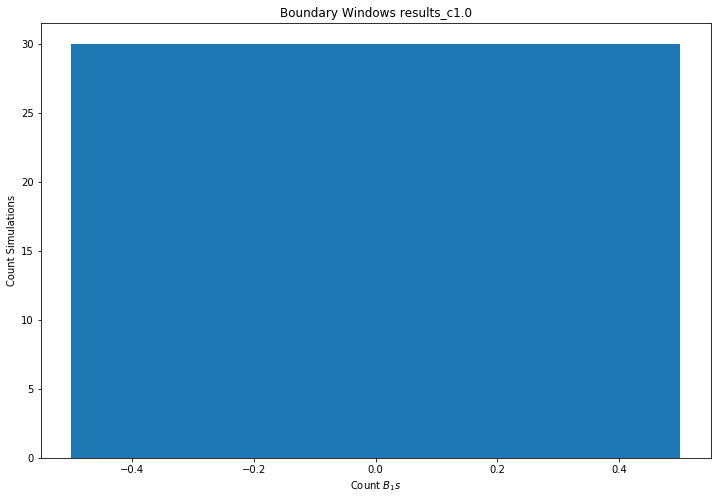

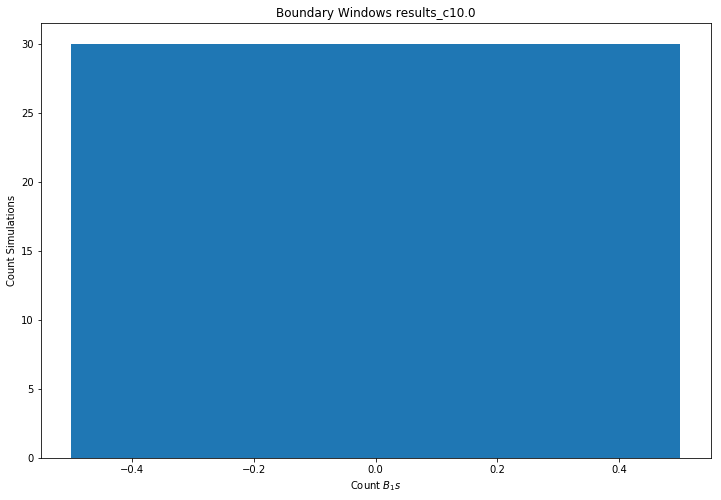

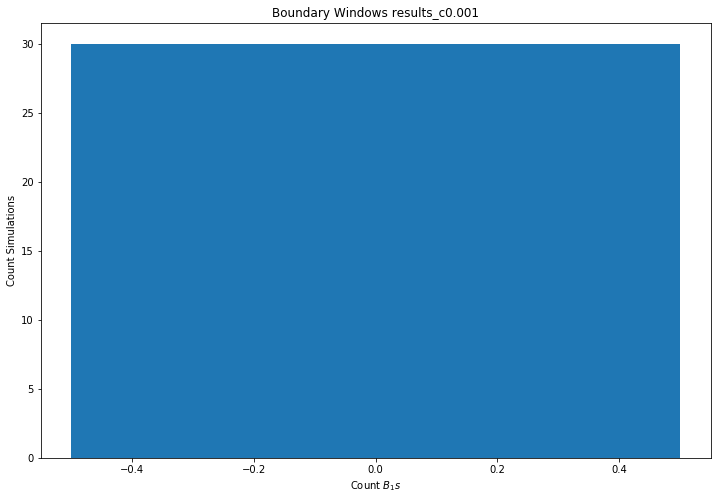

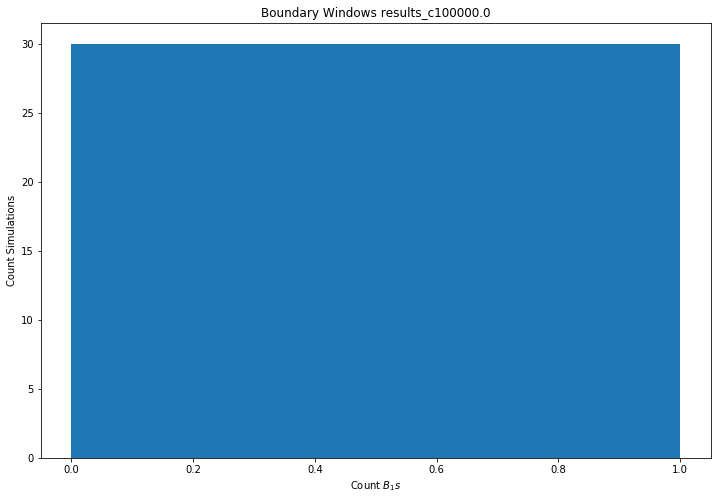

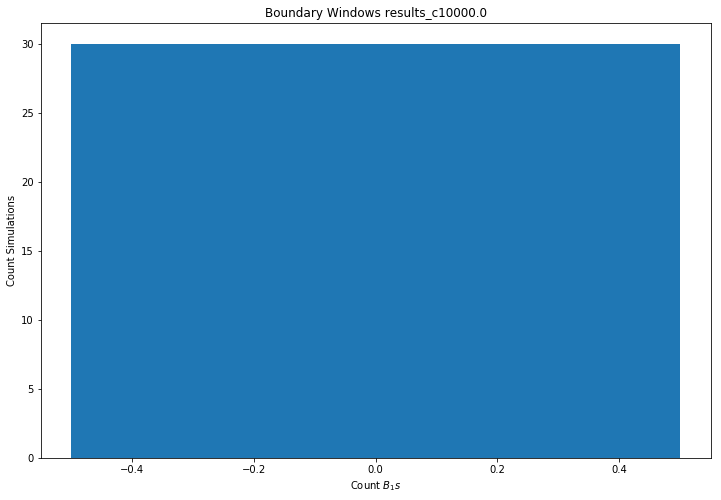

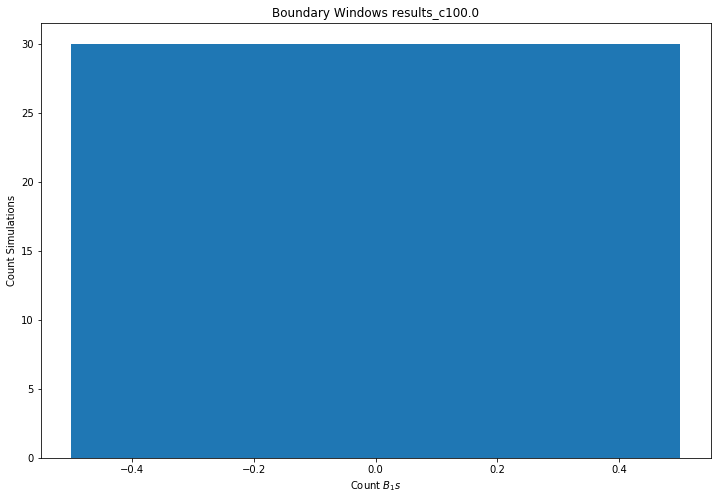

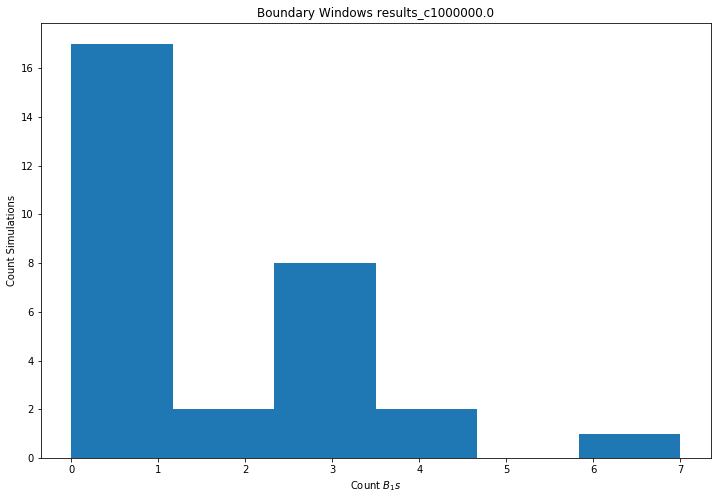

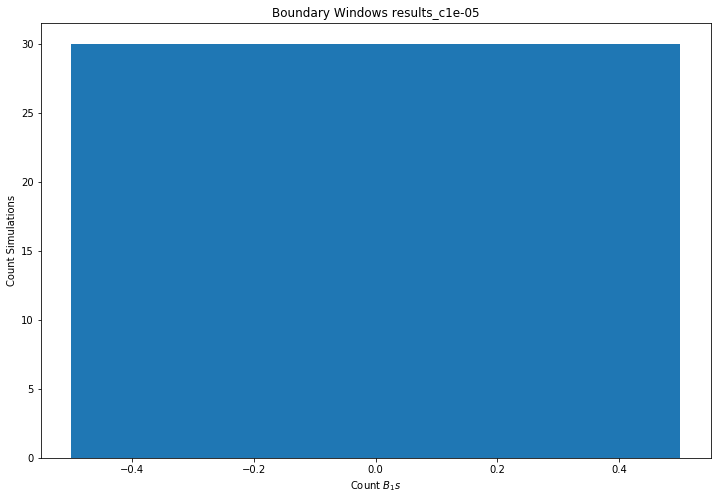

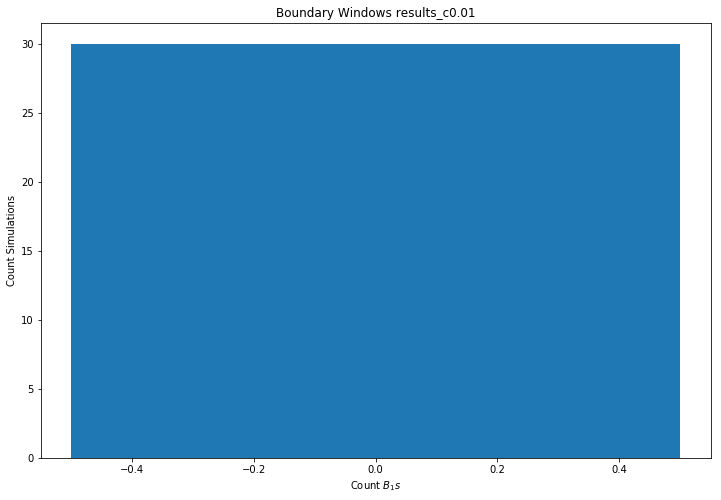

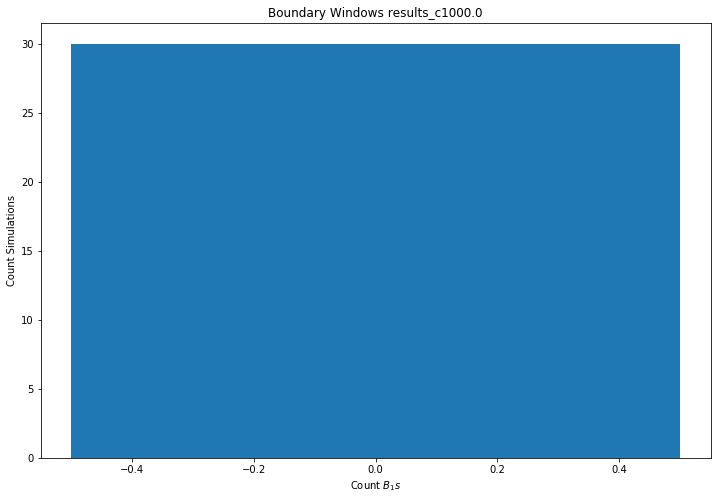

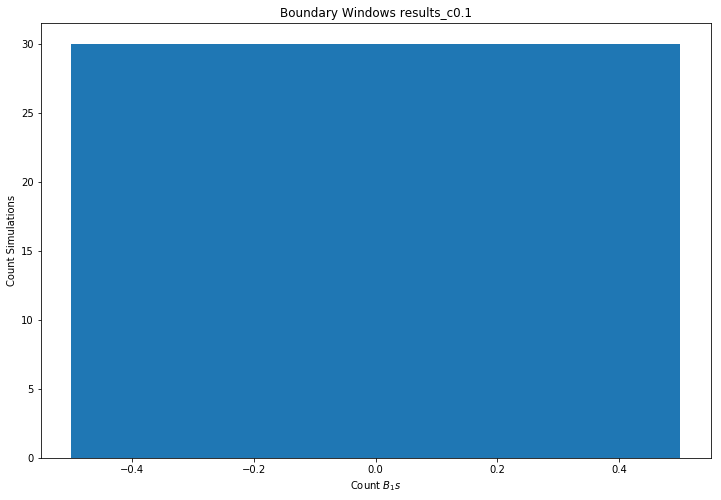

In [40]:
paths = get_list_of_dir_contents('TDA_results')
for path in paths:
    if '_c' not in path:
        continue
    try:
        hist_of_b1s(path)
    except:
        continue

The following histograms show the distribution of B1 feature counts across simulations with the default above parameters but varying window size as a percent of size_pop.

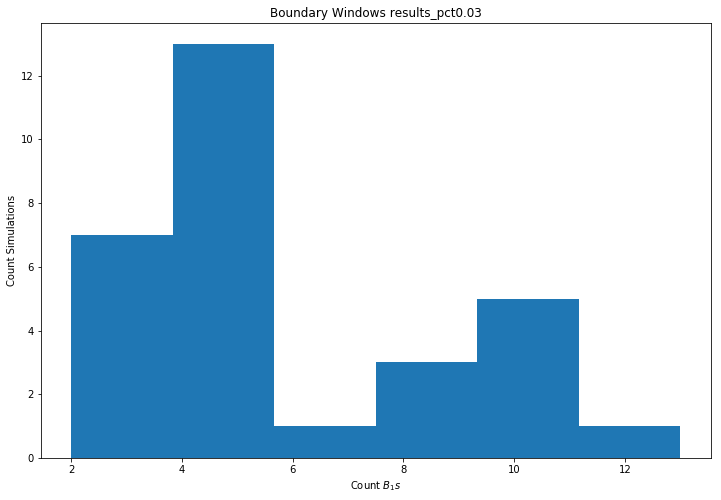

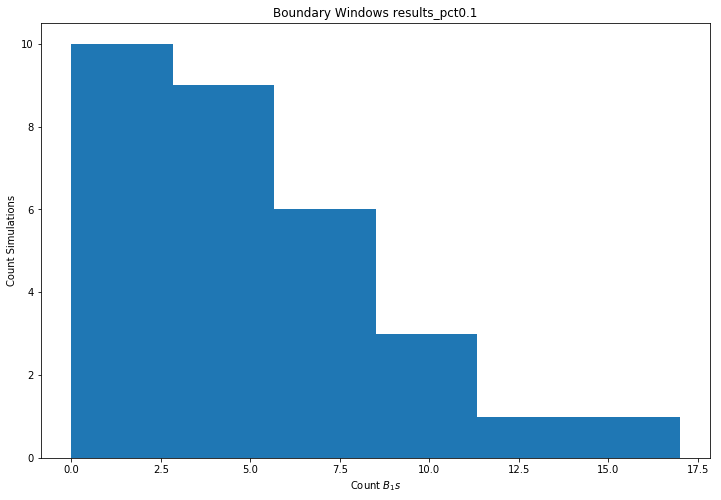

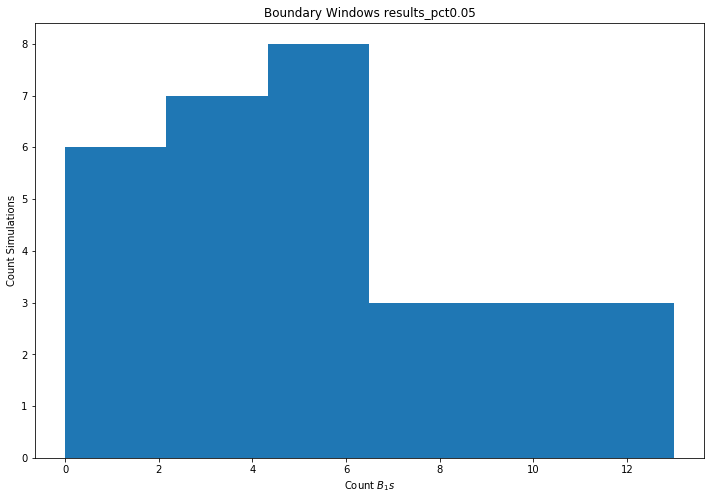

In [41]:
paths = get_list_of_dir_contents('TDA_results')
for path in paths:
    if '_c' in path:
        continue
    try:
        hist_of_b1s(path)
    except:
        continue

Something particularly interesting about varying the window size is that this distribution appears to smooth over with increasing percent width. Note: it takes about an hour or two to make one of these graphs, so when choosing parameter grids, do so wisely. 

### Discussion & Future Work

Persistent Homology methods are well suited for evolutionary inference problems that require complex network structures. In this project, we provide the software to automate analysis of the effect of crossover, gene conversion, and other msHOT parameters on the H1 features created by the rips filtration on its simulated data. In the future, we'd like to work on strategies to differentiate the two reticulate events (gene conversion + crossover) via further simulation and algorithmic attempts. An idea to consider is, if crossover leaves an obvious signature, is there any way to mute its noise o

In [25]:
%reload_ext rpy2.ipython
%matplotlib inline
from sklearn.externals.joblib import load, dump
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import time
import os
import glob

In [26]:
TIME = time.strftime('%H-%M-%S')
msHOT_PATH = '~/msHOT/'

In [27]:
%%R
get_xy <- function(i){
    return(gcds11[[i]])
}

In [29]:
%%R
library(TDA)
TDA <- function(x) {
    distance_mat <- dist(x, method = "manhattan")
    rips_diag <- ripsDiag(distance_mat, maxdimension = 2, maxscale = max(distance_mat), dist = "arbitrary", library = "GUDHI")
    #one <- which(rips_diag[["diagram"]][,1]==1)
    return(rips_diag[["diagram"]])
}

In [30]:
def get_list_of_dir_contents(path, only_fns_with_str='', return_fns_only=False):
    directory_contents = glob.glob(os.path.join(path, '*'))
    dir_contents = []
    for path in directory_contents:
        fn = path.split('/')[-1]
        if only_fns_with_str not in fn:
            continue
        if return_fns_only:
            dir_contents.append(fn)
        else:
            dir_contents.append('/'.join(path.split('/')[:-1] + [fn]))
    return dir_contents

In [31]:
def R_gcds11_to_df(pts):
    py_pts=[]
    for i in pts:
        pt = list(i.transpose())
        if len(pt)==2:
            py_pts.append(pt)
        else:
            print(len(pt), 
                 'huh')
    return py_pts

In [32]:
def write_msHOT(n_simulations=30, size_pop=100, r=.001, size_seq=100001,
                c=100000.0, tract_length=100, s=100):

    FN = 'sims/pop' + str(size_pop) + '_r' + str(r) + '_seqsize' + str(size_seq) + '_c' + str(c) \
            + '_trlen' + str(tract_length) + '_s' + str(s) + '.txt'

    if c is None or tract_length is None:
        cmd = msHOT_PATH + './msHOT ' + str(size_pop) + ' ' + str(n_simulations) \
            + ' -r ' + str(r) + ' ' + str(size_seq) + ' -s ' + str(s) + ' > ' + FN
    else:
        cmd = msHOT_PATH + './msHOT ' + str(size_pop) + ' ' + str(n_simulations) \
            + ' -r ' + str(r) + ' ' + str(size_seq) + ' -c ' + str(c) + ' ' \
            + str(tract_length) + ' -s ' + str(s) + ' > ' + FN
    os.system(cmd)
    return FN

In [33]:
def fixed_window(simulation, window_pct=0.05):
    window_snp_size = int(window_pct * simulation.shape[1])
    left = simulation[:, :window_snp_size]
    right = simulation[:, -window_snp_size:]
    window = np.append(arr=left, values=right, axis=1)
    return window

In [34]:
def load_msHOT(n_simulations=30, size_pop=100, r=100, size_seq=100001,
                c=100000.0, tract_length=100, s=100, path_to_prewritten=None):
    if path_to_prewritten == None:
        fn = write_msHOT(n_simulations, size_pop, r, size_seq, c,
                        tract_length, s)
    else:
        fn = path_to_prewritten
    raw_file = open(fn)
    list_of_sims = raw_file.read().split('\n\n')[2::2]
    processed_sims = []
    for simulation in list_of_sims:
        lines = simulation.strip().split('\n')
        pos = [float(pct) for pct in lines[0].split(' ')[1:-1]]
        snp_rows = []
        for row in lines[1:]:
            snp_rows.append([int(indicator) for indicator in row])
        snp_df = pd.DataFrame(data=snp_rows, columns=pos)
        processed_sims.append(snp_df)
    return processed_sims

In [35]:
def pyTDA(window):
    distmat = pdist(window, 'cityblock')
    rips = rips_filtration(distmat, )
    return rips

In [36]:
def batch_TDA(simulations, window_pct=0.05):
    all_results = []
    for sim in simulations:
        wind = fixed_window(sim.values)
        %R -i wind
        %R -o results results <- TDA(wind)
        print(results)
        all_results.append(list(results.T))
    print(all_results[:5])
    return all_results

In [42]:
def hist_of_b1s(results_pkl_path):
    results = load(results_pkl_path)
    title = results_pkl_path.split('/')[-1].split('.pkl')[0]
    stats_list = []
    for b1s, birth, death in results:
        stats_list.append({'mean': b1s.mean(), 'sd': b1s.std(),
                           'count': b1s.sum()})
    df = pd.DataFrame(stats_list, index=range(len(stats_list)))
    df.index.rename(name='row_num', inplace=True)
    df.to_csv(results_pkl_path[:-4] + '.csv')
    
    fig, ax = plt.subplots()
    ax.hist(df['count'].T, bins='auto')
    fig.set_size_inches(h=8, w=12)
    ax.set_xlabel('Count $B_1s$')
    ax.set_ylabel('Count Simulations')
    ax.set_title('Boundary Windows ' + title)
    fig.savefig('figs/' + title + '.png')

TDA_results/results_c10000.0.csv
TDA_results/results_c1000000.0.csv
TDA_results/results_c1000.0.csv
TDA_results/results_c10.0.csv
TDA_results/results_pct0.03.csv
TDA_results/results_c0.1.csv
TDA_results/results_c100.0.csv
TDA_results/results_c100000.0.csv
TDA_results/results_pct0.05.csv
TDA_results/results_c0.01.csv
TDA_results/results_c1.0.csv
TDA_results/results_c0.001.csv
TDA_results/results_pct0.1.csv
TDA_results/results_c1e-05.csv


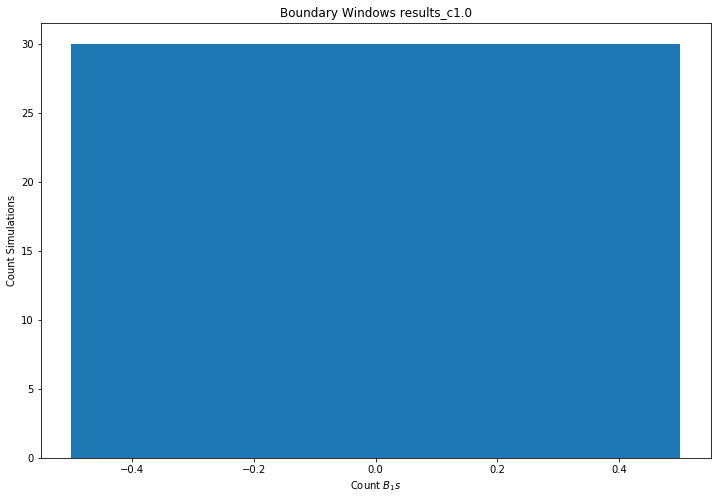

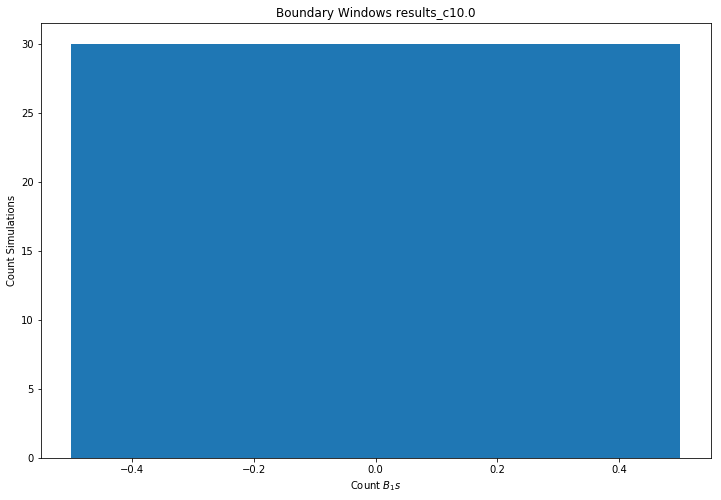

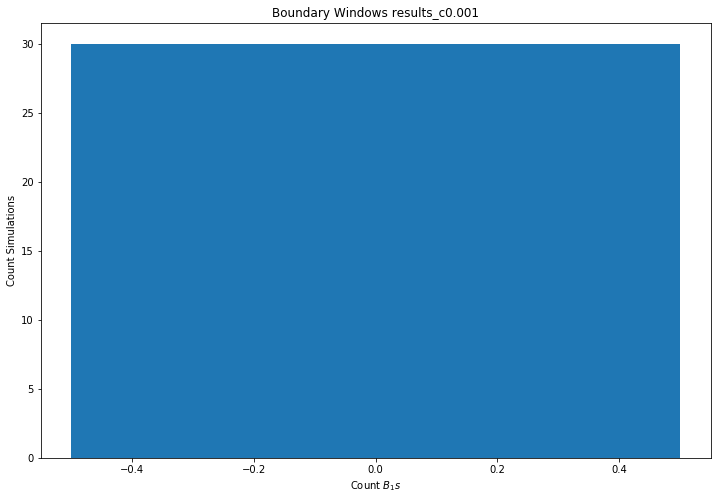

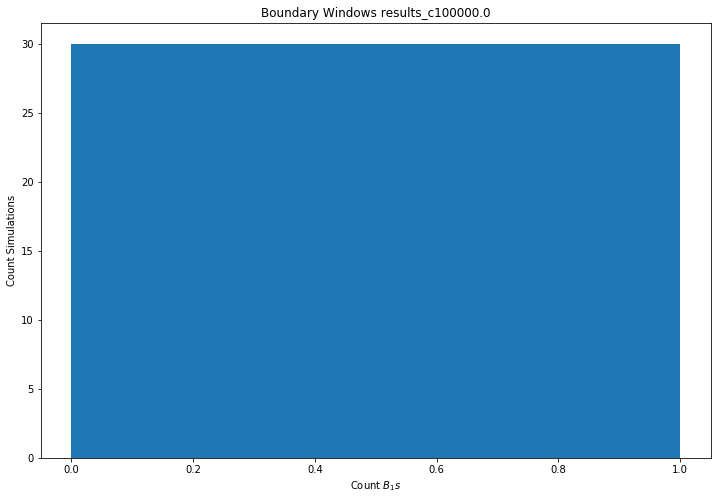

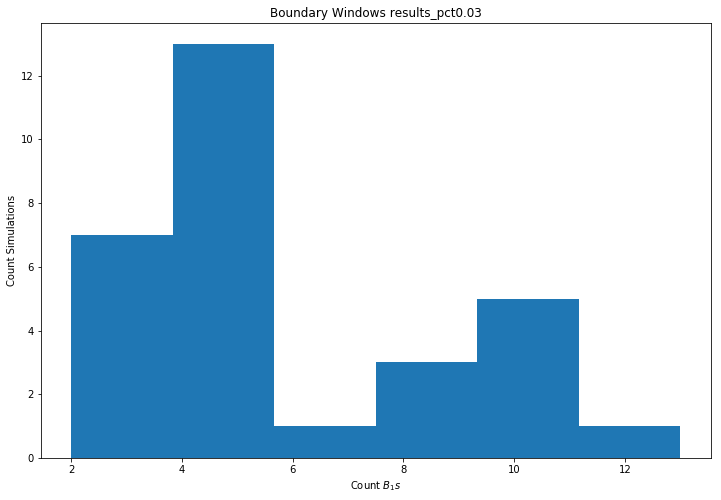

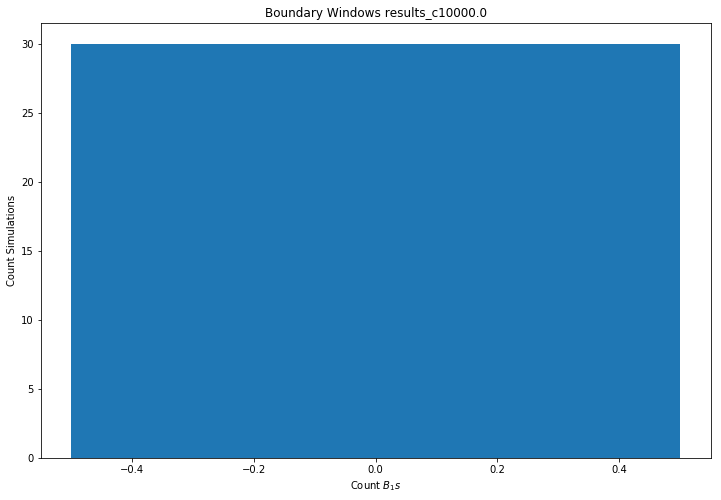

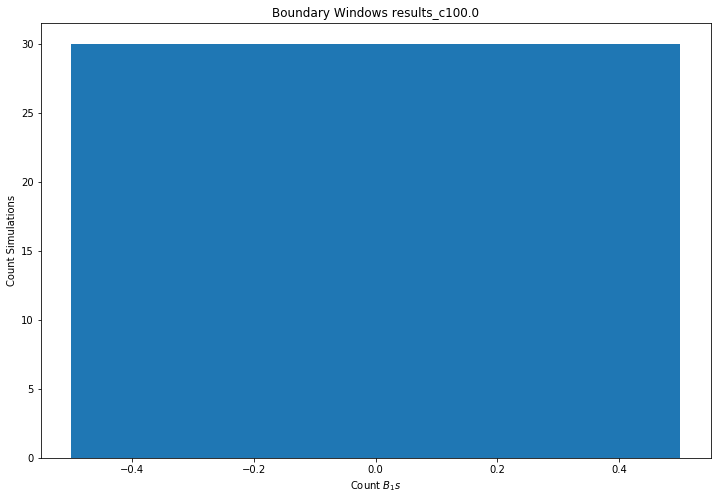

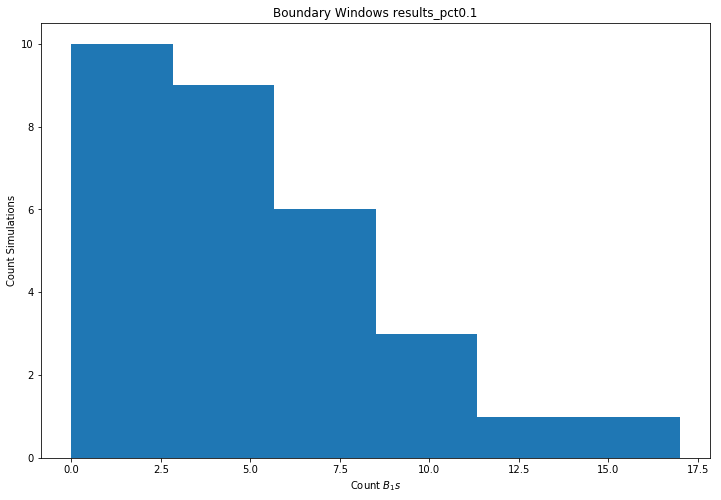

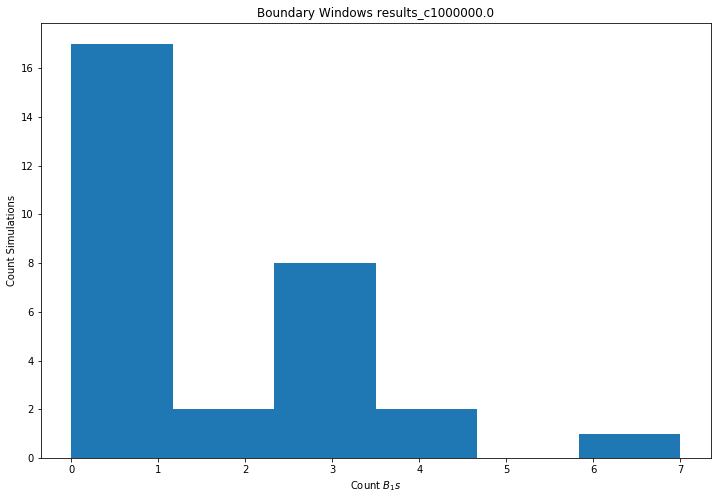

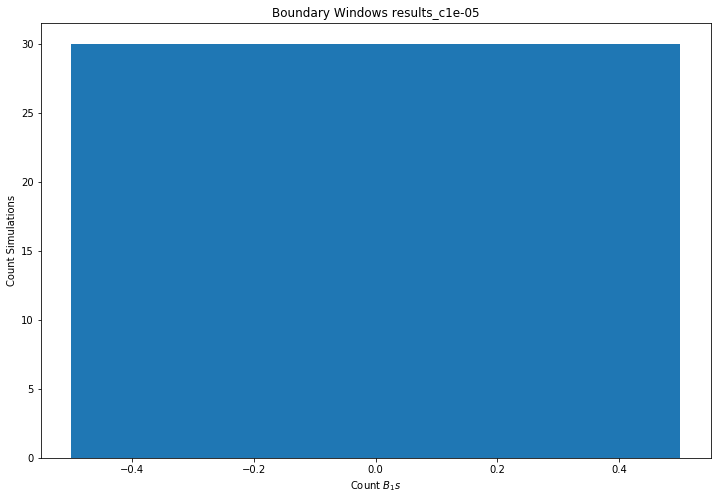

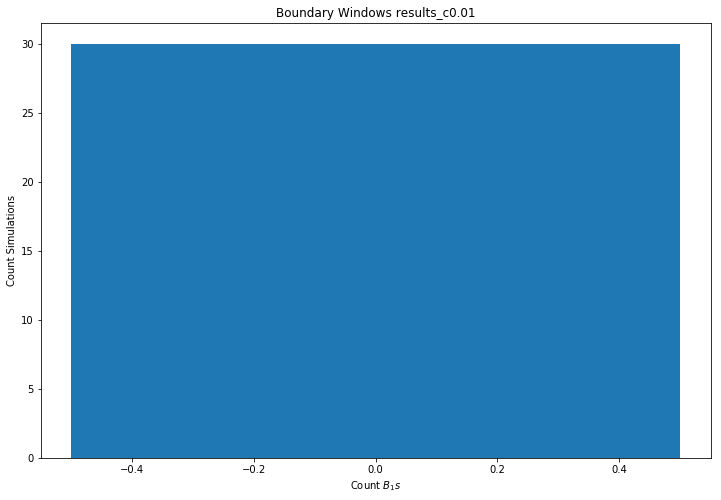

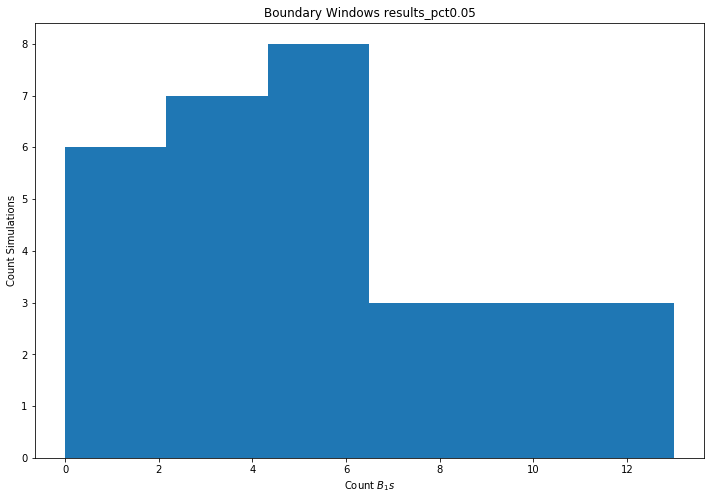

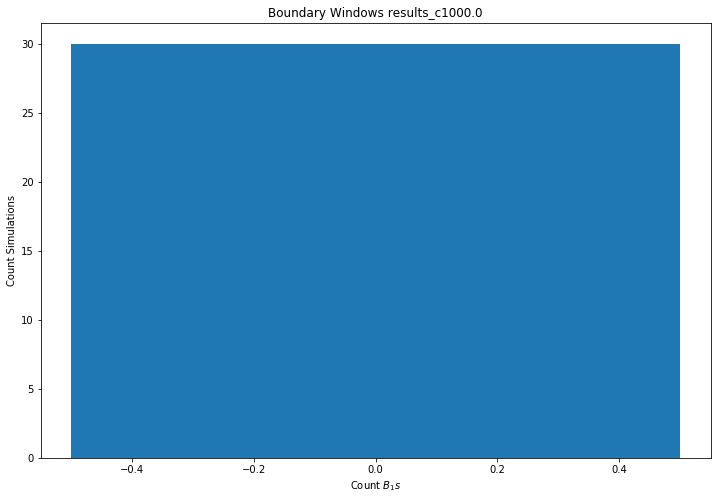

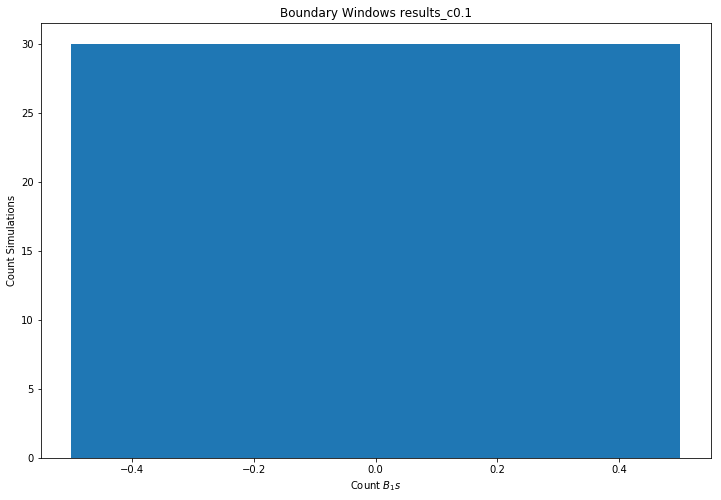

In [19]:
for pct in [0.15]: #0.15, 0.2, 0.25][::3]:
    sims = load_msHOT(c=None)
    results = batch_TDA(sims, window_pct=pct)
    dump(results, 'TDA_results/results_pct' + str(pct) + '.pkl')


Error in TDA(wind) : could not find function "TDA"


/usr/local/lib/python3.4/dist-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Error in TDA(wind) : could not find function "TDA"

  warnings.warn(x, RRuntimeWarning)


NameError: name 'results' is not defined

In [ ]:
for c_val in [1000000.0,10000000.0,100000.0][2::3]:
    sims = load_msHOT(c=c_val)
    results = batch_TDA(sims)
    dump(results, 'TDA_results/results_c' + str(c_val) + '.pkl')

In [17]:
m = load_msHOT(path_to_prewritten='/home/max/Desktop/TDA/sims/pop100_r0.001_seqsize100001_c10000.0_trlen100_s100.txt')

In [27]:
pdist(m[0].values, 'cityblock')
k = m[0]
%R -i k
%R -o results results <- TDA(k)

array([ 6.,  2.,  6., ...,  0.,  1.,  1.])

In [28]:
results

array([ 6.,  2.,  6., ...,  0.,  1.,  1.])

In [ ]:
rips_filtration()

In [ ]:
# dump(results, 'results_cross.pkl')

In [ ]:
# np.array(load('results_cross.pkl')).shape

In [ ]:
# all_coords = []
# for i in range(1,301):
#     %R -o pts pts <- get_xy(i)
#     all_coords.append(R_gcds11_to_df(pts))
# coords_array = np.array(all_coords)

In [ ]:
%%R
get_xy <- function(i){
    return(gcds11[[i]])
}

In [ ]:
%%R
gamete.count<-function(datafr) {  
    datav<-c(rep(0,6))
    sortdf<-data.frame(1,2,3,4,5,6)
    colnames(sortdf)<-c("r1","r2","oo","io","oi","ii")
    for (i in 1:99)  { 
        for (j in (i+1):100)  {
          datav[1]<-i
          datav[2]<-j
        for (r in 1:100)  {
          if (datafr[r,i]==0 & datafr[r,j]==0) {
            datav[3]=datav[3]+1 }
          if (datafr[r,i]==1 & datafr[r,j]==0) {
            datav[4]=datav[4]+1 }
          if (datafr[r,i]==0 & datafr[r,j]==1) {
            datav[5]=datav[5]+1 }
          if (datafr[r,i]==1 & datafr[r,j]==1) {
            datav[6]=datav[6]+1 }

        }
      sortdf<-rbind(sortdf,datav)
      datav<-c(rep(0,6))
        }
    }
    sortdf<-sortdf[-1,]
    return(four.gametes<- subset(sortdf, oo>0 & io>0 & ii>0 & oi > 0)) 
}